In [73]:
import torch
import time
import gc
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
from copy import deepcopy 
from tabulate import tabulate
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import ConfusionMatrixDisplay
from collections import namedtuple
import plotly.express as px

In [2]:
### Basic structure

DATA_DIR = "data/"
STOCKFISH_DIR = 'stockfish/'
ARCHIVE_DIR = DATA_DIR + 'archives/'

###
##
###

### Stockfish

STOCKFISH_AVX512_TAR = "stockfish-ubuntu-x86-64-avx512.tar"
STOCKFISH_AVX512 = "stockfish-ubuntu-x86-64-avx512"
STOCKFISH_AVX512_EXE = STOCKFISH_DIR + STOCKFISH_AVX512


###
##
###

### URLs

ELITE_DATABASE_URL  = "https://database.nikonoel.fr/lichess_elite_2021-11.zip"
STOCKFISH_DOWNSTREAM = "https://github.com/official-stockfish/Stockfish/releases/latest/download/"
STOCKFISH_AVX512_URL = STOCKFISH_DOWNSTREAM + STOCKFISH_AVX512_TAR

### 
##
###

### Datasets 

ELITE_DATASET_ARCHIVE = "lichess_elite_2021-11.zip"
ELITE_DATASET_FILENAME = "lichess_elite_2021-11.pgn"


LICHESS_EVAL_ARCHIVE = ARCHIVE_DIR + "lichess_db_eval.jsonl.zst"
LICHESS_EVAL_FILENAME = DATA_DIR + "lichess_db_eval.jsonl"


In [3]:
BITBOARD_DIR = DATA_DIR + 'bitboards/'
ELITE_DATA_BASE_URL  = "https://database.nikonoel.fr/"
STOCKFISH_DOWNSTREAM = "https://github.com/official-stockfish/Stockfish/releases/latest/download/"

SAMPLE_ZIP = "lichess_elite_2021-11.zip"
SAMPLE_PGN = "lichess_elite_2021-11.pgn"
SAMPLE_BITBOARD = "elite_bitboard.csv"
BITBOARD_1M = "1M.csv"
BITBOARD_10M = "10M.csv"
ELITE_DATA_SAMPLE_URL = ELITE_DATA_BASE_URL + SAMPLE_ZIP
SAMPLE_ZIP_FILE = ARCHIVE_DIR + SAMPLE_ZIP
SAMPLE_PGN_FILE  = DATA_DIR + SAMPLE_PGN

SAMPLE_BITBOARD_FILE = BITBOARD_DIR + SAMPLE_BITBOARD
BITBOARD_10M_FILE = BITBOARD_DIR + BITBOARD_10M
BITBOARD_1M_FILE = BITBOARD_DIR + BITBOARD_1M

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
torch.cuda.is_available()

True

In [5]:
class BitboardDrawDatasetSimple(Dataset):
    def __init__(self, bitboard_file):
        bitboards_df = pd.read_csv(bitboard_file, sep=";", dtype="uint64", usecols=range(12))
        metadata_df = pd.read_csv(bitboard_file, sep=";")

        self.bitboards = self.bitboards_to_layers(bitboards_df)
        # self.meta_features = self.binary_features_to_layers(metadata_df[["white", "cK", "cQ", "ck", "cq"]])
        self.is_draw = metadata_df['draw'].to_numpy(dtype=np.single)
        self.length = self.is_draw.size

        # self.bitboards = np.hstack((self.bitboards, self.meta_features))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.bitboards[idx], self.is_draw[idx]

    def bitboards_to_layers(self, bitboards):
        return np.unpackbits(np.ascontiguousarray(bitboards.to_numpy()).view(np.uint8), axis=1).astype(np.single)

    def binary_features_to_layers(self, features):
        return np.unpackbits(np.ascontiguousarray((features.to_numpy(dtype=np.uint64) - 1) ^ 0xffffffffffffffff).view(np.uint8), axis=1).astype(np.single)

In [6]:
class BitboardDrawDataset(Dataset):

    @classmethod
    def from_dataset_info(cls, dataset_info):
        return cls(dataset_info.source_file, dataset_info.chunk_size, dataset_info.shuffle, dataset_info.in_memory)
    
    def __init__(self, bitboard_file, chunk_size, shuffle = True, in_memory = False):
        self.curr_batch = 0
        self.shuffle = shuffle
        self.bitboard_file = bitboard_file
        self.chunk_size = chunk_size
        self.datasamples = self.calculate_dataset_size()
        
        self.batches = ceil(self.datasamples / chunk_size)
        self.splits = np.arange(chunk_size, self.datasamples, chunk_size)
        self.indices = np.arange(1, self.datasamples+1)
        self.splits = np.append(self.splits, [0])

        self.in_memory = in_memory or self.chunk_size == self.datasamples
        
        self.load_data()
    
    def __len__(self):
        return self.datasamples
        
    def __getitem__(self, idx):
        batch = idx // self.chunk_size
        # Laod new data 
        if self.curr_batch != batch and not self.in_memory:
            self.curr_batch = batch
            self.load_data()            

        idx -= self.chunk_size * self.curr_batch
        
        return self.bitboards[idx], self.is_draw[idx]

    def bitboards_to_layers(self, bitboards):
        return np.unpackbits(np.ascontiguousarray(bitboards.to_numpy()).view(np.uint8), axis=1).astype(np.single)

    def binary_features_to_layers(self, features):
        return np.unpackbits(np.ascontiguousarray((features.to_numpy(dtype=np.uint64) - 1) ^ 0xffffffffffffffff).view(np.uint8), axis=1).astype(np.single)

    def load_data(self):
        if self.curr_batch == 0 and self.shuffle:
            np.random.shuffle(self.indices)
            
        ignore = set(self.indices)

        if self.curr_batch == self.batches-1:
            ignore.difference_update(self.indices[self.splits[self.curr_batch-1]:])
        else:
            ignore.difference_update(self.indices[self.splits[self.curr_batch-1]:self.splits[self.curr_batch]])

        df = pd.read_csv(self.bitboard_file, sep=";", dtype="uint64", usecols=range(18), skiprows=ignore)
        self.bitboards = self.bitboards_to_layers(df.iloc[:, range(12)])
        # self.meta_features = self.binary_features_to_layers(df[["white", "cK", "cQ", "ck", "cq"]])
        self.is_draw = df['draw'].to_numpy(dtype=np.single)

        # self.bitboards = np.hstack((self.bitboards, self.meta_features))
    
    def calculate_dataset_size(self):
        with open(self.bitboard_file) as f:
            return sum(1 for line in f) - 1

    def dataloader(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=self.in_memory, pin_memory=True, pin_memory_device=device.type)


In [7]:
DatasetInfo = namedtuple("DatasetInfo", ["source_file", "chunk_size", "shuffle", "in_memory"])

In [8]:
class ConvolutionNetwork(nn.Module):

    def __init__(self, neurons=256):
        super().__init__()
        self.neurons = neurons
        self.model = nn.Sequential(
            nn.Unflatten(1, (13, 8, 8)),
            nn.Conv2d(13, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(1),
            
            nn.Linear(64 * 2 * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model.forward(x)

In [9]:
class DenseNetwork(nn.Module):

    def __init__(self, layers, sizes):
        super().__init__()
        self.sizes = sizes
        self.layers = layers
        ll = []

        assert self.layers == len(sizes) - 2, "Wrong layers to sizes number."
        
        for i in range(layers+1):
            ll.append(nn.Linear(self.sizes[i], self.sizes[i+1]))   
            if i < layers:
                if layers > 1:
                    ll.append(nn.BatchNorm1d(self.sizes[i+1]))
                ll.append(nn.ReLU())
                
        self.model = nn.Sequential(*ll)

    def forward(self, x):
        return self.model.forward(x)

    def __str__(self):
        return f"Dense_{'_'.join(map(str, self.sizes))}"

In [10]:
def sizeof_fmt(num, suffix="B"):
    for unit in ("", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"):
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"

print(f"Allocated: {sizeof_fmt(torch.cuda.memory_allocated())}") 
print(f"Reserved: {sizeof_fmt(torch.cuda.memory_reserved())}") 

Allocated: 0.0B
Reserved: 0.0B


In [11]:
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f"Took: {te-ts:.2f}s")
        return result
    return timed

class Train:
    
    def __init__(self, train_dataset_info, validate_dataset_info, batch_size):
        self.batch_size = batch_size
        self.train_dataset = BitboardDrawDataset.from_dataset_info(train_dataset_info)
        self.validate_dataset = BitboardDrawDataset.from_dataset_info(validate_dataset_info)
        self.train_dataloader = self.train_dataset.dataloader(batch_size)
        self.validate_dataloader = self.validate_dataset.dataloader(batch_size)

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.total_batches = len(self.train_dataloader)
        self.print_every = 100
        self.epoch_print_interval = 1
        
    def train_one_epoch(self, model, optimizer, p=False) -> int:
        running_loss = 0.
        last_loss = 0.
    
        for i, data in enumerate(self.train_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.unsqueeze(1).to(device)
    
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            if i % self.print_every == self.print_every - 1:
                last_loss = running_loss / self.print_every
                if p: print(f"  batch {i+1} loss: {last_loss}")
                running_loss = 0.
            elif i == self.total_batches - 1:
                last_loss = running_loss / (i % self.print_every + 1)
                if p: print(f"  batch {i+1} loss: {last_loss}")
            
        return last_loss
    
    @timeit
    def train(self, model, optimizer, epochs, p=True):
        try:
            best_vloss = np.inf
            best_model = deepcopy(model.state_dict())
            best_epoch = 0
            best_acc = 0
        
            for epoch in range(1, epochs + 1):
                if p and epoch % self.epoch_print_interval == 0 or epoch == 1: print(f'EPOCH {epoch}')
            
                # Make sure gradient tracking is on, and do a pass over the data
                model.train(True)
                avg_loss = self.train_one_epoch(model, optimizer)
            
                model.eval()
    
                with torch.no_grad():
                    train_acc, train_loss, train_prec, train_recall = self.test(model, self.train_dataloader)
                    # train_acc, train_loss, train_prec, train_recall = 0, 0, 0, 0
                    validate_acc, validate_loss, validate_prec, validate_recall = self.test(model, self.validate_dataloader)
    
                    if p and epoch % self.epoch_print_interval == 0 or epoch == 1: 
                        print(tabulate([["Loss", train_loss, validate_loss], 
                                        ["Precision", train_prec, validate_prec],
                                        ["Recall", train_recall, validate_recall],
                                        ["Accuracy", f"{train_acc:.2f}%", f"{validate_acc:.2f}%"]],
                                       headers=["", "Train", "Test"]))
            
                if validate_loss < best_vloss:
                    best_vloss = validate_loss
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_acc = validate_acc
                    
        except KeyboardInterrupt:
            self.save_model(model, best_model, best_epoch, lr, momentum, acc)

        return best_model, best_epoch, best_acc

    def test(self, model, dataloader):
        acc, loss = 0, 0
        conf_mat = torch.zeros(2, 2) 
        for i, (vinputs, vlabels) in enumerate(dataloader):
            vinputs, vlabels = vinputs.to(device), vlabels.unsqueeze(1).to(device)
            voutputs = model(vinputs)
            pred = nn.functional.sigmoid(voutputs).round()
            
            acc += (pred == vlabels).sum() / self.batch_size
            loss += self.loss_fn(voutputs, vlabels) 
            # conf_mat += confusion_matrix(vlabels.to('cpu'), pred.to('cpu'))

        acc = acc / (i+1) * 100
        loss /= (i+1)

        prec = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[0, 1])
        recall = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])
        
        return acc, loss, prec, recall
    
    
                
    def save_model(self, model, state_dict, epoch, lr, momentum, acc):
        model_path = f"models/1M/0l/{str(model)}_b{self.batch_size}_e{epoch}_lr{lr}_m{momentum}_acc{acc:.2f}"
        torch.save(state_dict, model_path)
        
    
    def find_best_neuron(self, model, epochs, lr=1e-3, momentum=0.9):
        print(str(model))
        model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        # optimizer = optim.Adam(model.parameters())
        best_model_state_dict, epoch, acc = self.train(model, optimizer, epochs)
        self.save_model(model, best_model_state_dict, epoch, lr, momentum, acc)
        model.to('cpu')
        self.cleanup()
        print("")
            
    def cleanup(self):  
        gc.collect()
        torch.cuda.empty_cache()
        

In [34]:
eval_dataset_info = DatasetInfo("data/eval_dataset/bitboards/1000000_0_19_24.csv", 1000000, False, True)
validate_dataset_info = DatasetInfo("data/eval_dataset/bitboards/100000_1509579_19_24.csv", 1000000, False, True)

In [35]:
pipe = Train(eval_dataset_info, validate_dataset_info, 512)

In [32]:
# model = DenseNetwork(3, [768, 2**14, 2**11, 2**8, 1])
# model = DenseNetwork(3, [768, 768, 256, 128, 1])
model = DenseNetwork(0, [768, 1])
# model.load_state_dict(torch.load("models/1M/1l/Dense_768_768_1_b512_e8_lr0.001_m0.9_acc76.14", map_location="cpu"))

In [29]:
pipe.find_best_neuron(model, 50, lr=1e-2)

Dense_768_768_256_128_1
EPOCH 1
           Train               Test
---------  ------------------  -----------------
Loss       0.5323566794395447  0.538047194480896
Precision  nan                 nan
Recall     nan                 nan
Accuracy   73.30%              72.70%
EPOCH 2
           Train               Test
---------  ------------------  -------------------
Loss       0.4897651672363281  0.49190765619277954
Precision  nan                 nan
Recall     nan                 nan
Accuracy   76.22%              75.82%
EPOCH 3
           Train               Test
---------  ------------------  -------------------
Loss       0.4615202844142914  0.46572166681289673
Precision  nan                 nan
Recall     nan                 nan
Accuracy   77.96%              77.57%
EPOCH 4
           Train                Test
---------  -------------------  -------------------
Loss       0.42931368947029114  0.43084532022476196
Precision  nan                  nan
Recall     nan                  n

In [36]:
pipe.find_best_neuron(model, 50, lr=1e-2)

Dense_768_1
EPOCH 1
           Train               Test
---------  ------------------  ------------------
Loss       0.6205525994300842  0.6312245726585388
Precision  nan                 nan
Recall     nan                 nan
Accuracy   65.87%              64.01%
EPOCH 2
           Train               Test
---------  ------------------  ------------------
Loss       0.6178538203239441  0.6292203068733215
Precision  nan                 nan
Recall     nan                 nan
Accuracy   66.30%              64.20%
EPOCH 3
           Train               Test
---------  ------------------  ------------------
Loss       0.6164646148681641  0.6276595592498779
Precision  nan                 nan
Recall     nan                 nan
Accuracy   66.43%              64.39%
EPOCH 4
           Train               Test
---------  ------------------  ------------------
Loss       0.6155890226364136  0.6270232796669006
Precision  nan                 nan
Recall     nan                 nan
Accuracy   66.52% 

In [69]:
def conf_matrix(y_true, preds):
    t = preds & y_true
    f = t^1
    
    po = preds & 1
    pz = po^1
    
    to = y_true & 1
    tz = to^1

    a = (pz & tz).sum(axis=1)
    b = (po & tz).sum(axis=1)
    c = (pz & to).sum(axis=1)
    d = (po & to).sum(axis=1)
    return np.column_stack((a,b,c,d)).reshape(-1, 2, 2)
    
def precision_score(conf_mat):
    return conf_mat[:, 1, 1] / (conf_mat[:, 1, 1] + conf_mat[:, 0, 1])

def recall_score(conf_mat):
    return conf_mat[:, 1, 1] / (conf_mat[:, 1, 1] + conf_mat[:, 1, 0])


def test_model(model, validate_dataloader):
    SAMPLE_NUM = 99
    samples = np.linspace(0.01, 0.99, SAMPLE_NUM)
    
    model.to(device)
    model.eval()
    with torch.no_grad():   
        acc, loss = 0, 0
        conf_mat = np.zeros((SAMPLE_NUM, 2, 2))
        for i, (x, y_true) in enumerate(validate_dataloader):
            x, y_true = x.to(device), y_true.unsqueeze(1).to(device)
            voutputs = model(x)
            loss += nn.functional.binary_cross_entropy_with_logits(voutputs, y_true) 
            out = nn.functional.sigmoid(voutputs).cpu().numpy()
    
            y_true = y_true.cpu().numpy().astype(np.int8)
            preds = np.array([out > k for k in samples]).astype(np.int8)
            
            acc += (preds == y_true).sum(axis=1)
            conf_mat += conf_matrix(y_true, preds)
    
    conf_mat = conf_mat
    acc = (acc / len(validate_dataset) * 100).squeeze()
    loss = (loss / (i+1)).cpu().numpy()
    prec =  precision_score(conf_mat) * 100
    recall = recall_score(conf_mat)
    
    best_acc = np.argmax(acc)
    best_prec = np.nanargmax(prec)

    print(f"Loss: {loss}")
    print(f"Acc: {acc[best_acc]}%")
    print(f"Precision: {prec[best_acc]}")
    print(f"Recall: {recall[best_acc]}")
    
    fig = px.line(x=samples, y=acc, title="Accuracy")
    fig.show()
    fig = px.line(x=samples, y=prec, title="Precision")
    fig.show()

    ConfusionMatrixDisplay(conf_mat[best_acc].astype(np.int32)).plot(cmap='Oranges')
    ConfusionMatrixDisplay(conf_mat[best_prec].astype(np.int32)).plot(cmap='Oranges')

Loss: 0.0985584408044815
Acc: 96.184%
Precision: 95.22232416586479
Recall: 0.961996699296905


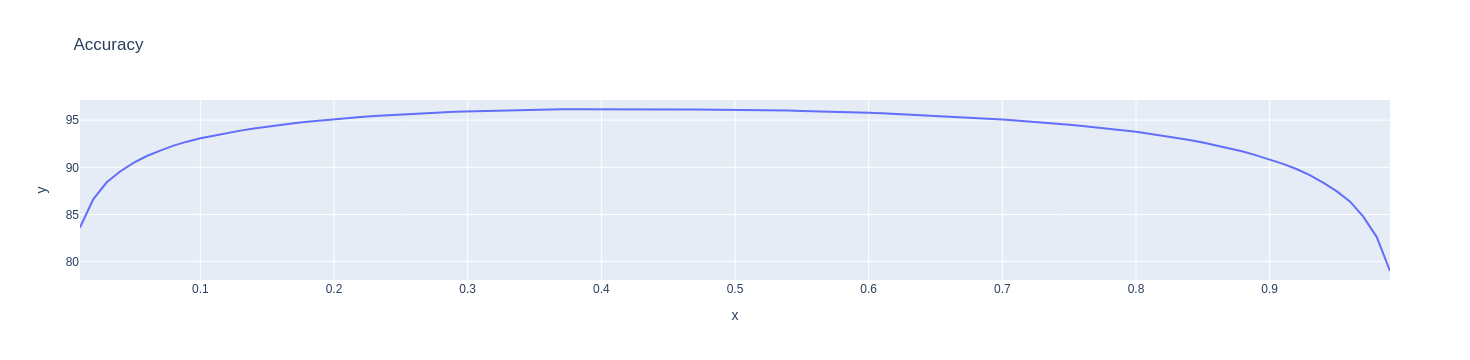

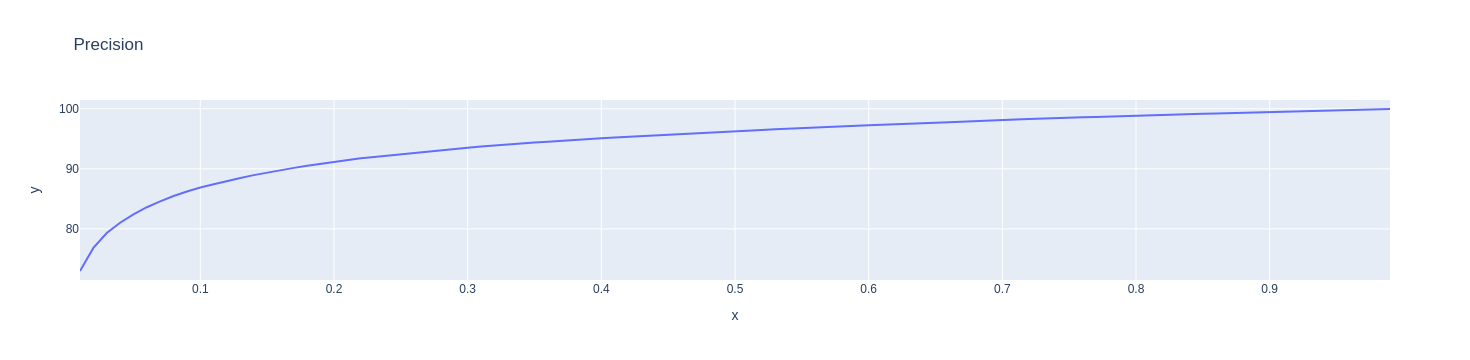

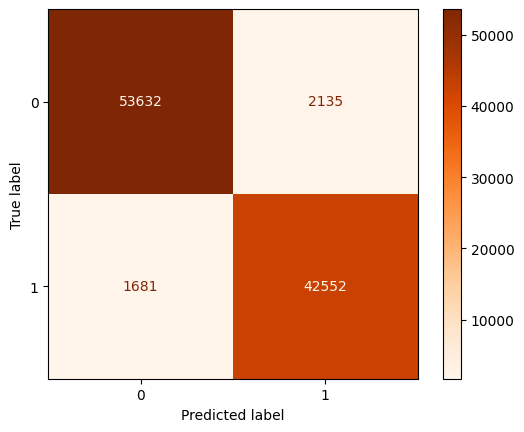

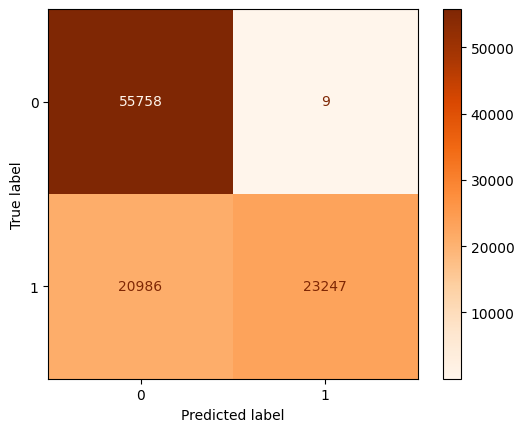

In [70]:
validate_dataset = BitboardDrawDataset("data/eval_dataset/bitboards/100000_1509579_19_24.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(3, [768, 768, 256, 128, 1])
model.load_state_dict(torch.load("models/1M/3l/Dense_768_768_256_128_1_b512_e50_lr0.01_m0.9_acc95.76", map_location=device))

test_model(model, validate_dataloader)

Loss: 0.6224418878555298
Acc: 65.509%
Precision: 62.894430326133
Recall: 0.5371329098184613


/tmp/ipykernel_1210618/1241753206.py:18: RuntimeWarning:

invalid value encountered in divide



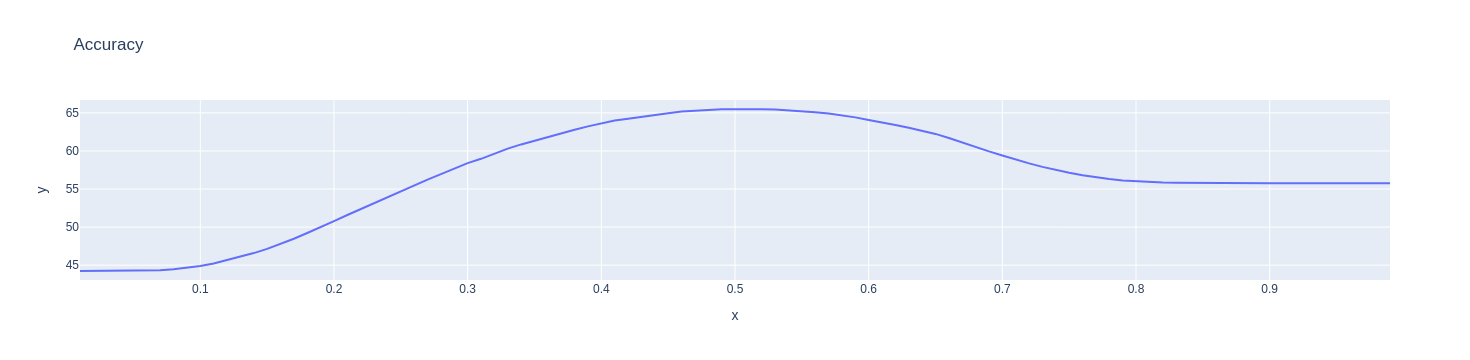

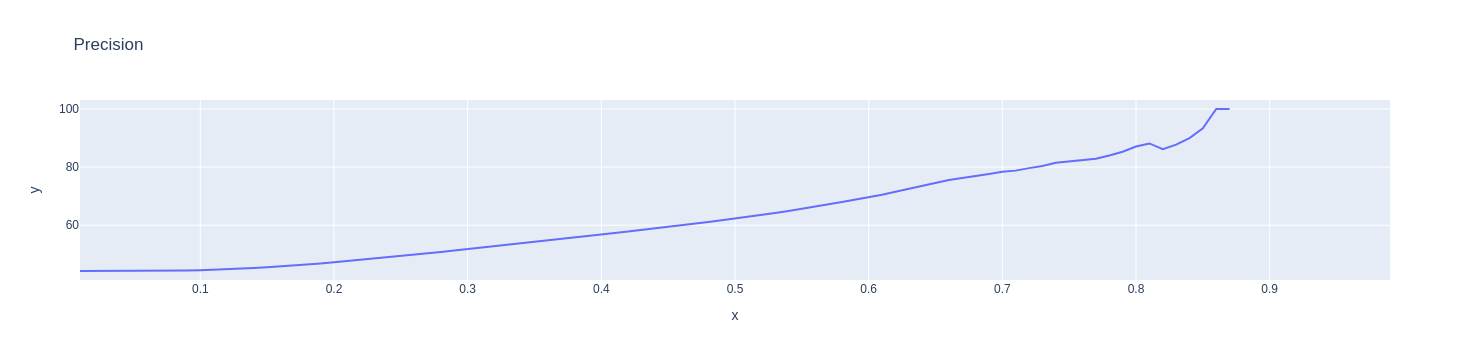

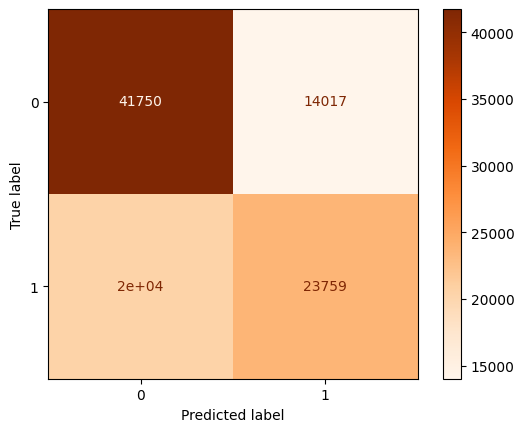

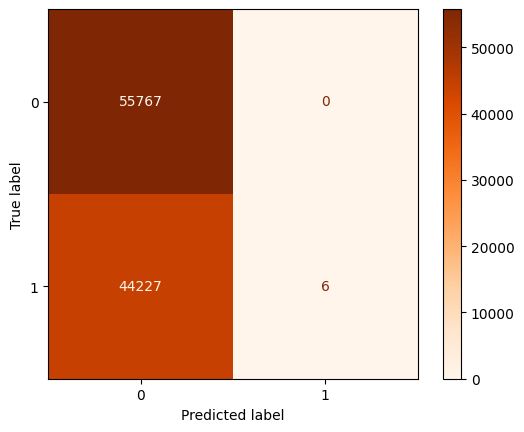

In [71]:
validate_dataset = BitboardDrawDataset("data/eval_dataset/bitboards/100000_1509579_19_24.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(0, [768, 1])
model.load_state_dict(torch.load("models/1M/0l/Dense_768_1_b512_e42_lr0.01_m0.9_acc65.25", map_location=device))

test_model(model, validate_dataloader)

In [76]:
def save_weights_to_csv(model: nn.Module, directory: str):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for name, param in model.named_parameters():
        layer_name, param_type = name.rsplit('.', 1)
        param_data = param.detach().cpu().numpy()
        df = pd.DataFrame(param_data)
        filename = f"{layer_name}_{param_type}.csv"
        df.to_csv(os.path.join(directory, filename), index=False)

    print(f"All weights and biases have been saved to the '{directory}' directory.")

save_weights_to_csv(model, 'models/weights/3l/')


All weights and biases have been saved to the 'models/weights/0l/' directory.


In [26]:
arr = [(logits > k).cpu().numpy() for k in np.linspace(0, 1, 1000)]
acc_arr = [((i == vlabels.cpu().numpy()).sum() / 1000) for i in arr]
print(max(acc_arr))
acc_arr.index(max(acc_arr))

6.84


610

In [27]:
tparr = []
for i in arr:
    tparr.append(precision_score(vdata[1].to('cpu'), i))

/home/jan/venv/nn-snake/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best value: 0.72
Cutoff: 0.918


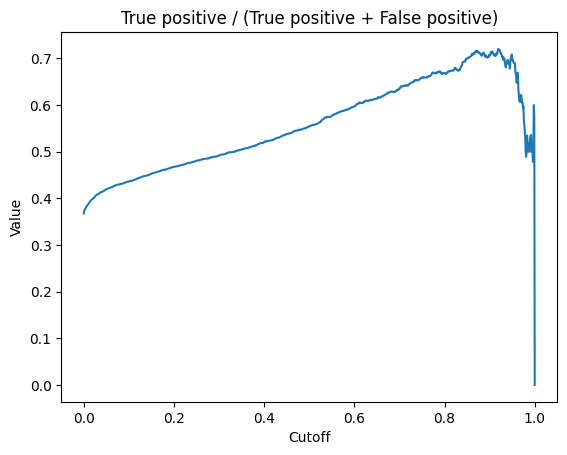

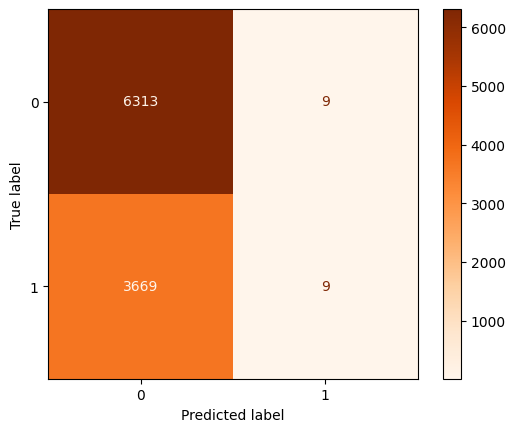

In [28]:
pred = logits > 0.997
plt.plot(np.linspace(0, 1, 1000), tparr)
plt.title("True positive / (True positive + False positive)")
plt.xlabel("Cutoff")
plt.ylabel("Value")
print(f"Best value: {max(tparr):.2f}\nCutoff: {tparr.index(max(tparr)) / 1000}")
cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
ConfusionMatrixDisplay(cm).plot(cmap='Oranges')

Best cutoff value: 0.61
Accuraccy : 68.40%


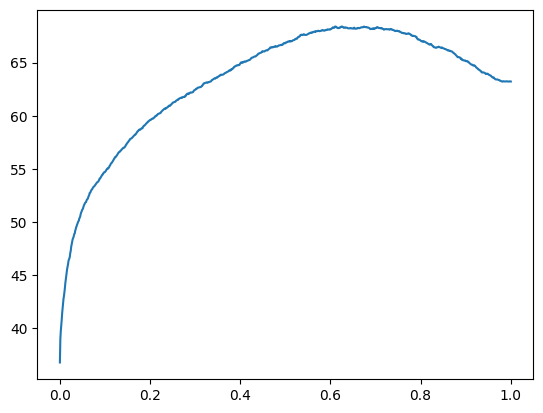

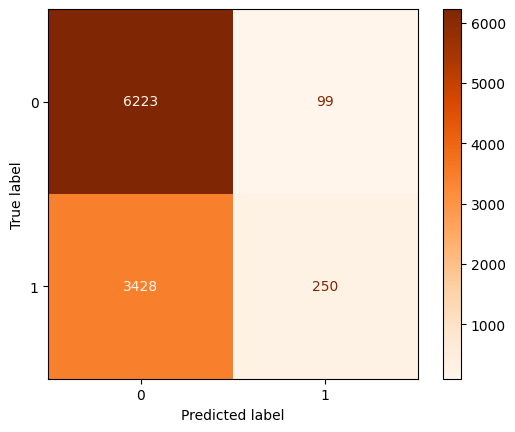

In [213]:
pred = logits > 0.918
plt.plot(np.linspace(0, 1, 1000), acc_arr)
print(f"Best cutoff value: {acc_arr.index(max(acc_arr)) / 1000}")
print(f"Accuraccy : {max(acc_arr):.2f}%")
cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
ConfusionMatrixDisplay(cm).plot(cmap='Oranges')

In [29]:
def unpack_to_bits(dataset):
    dataset.map(lambda x: ";".join(np.char.mod('%d', np.unpackbits(np.array([x]).view(np.uint8))))).to_csv("dataset_bits.csv", sep=";", index=False)
    bity = pd.read_csv("dataset_bits.csv", dtype="uint64", sep=";", header=None)
    dataset.rename(columns={"draw": 768})
    pd.concat([bity, dataset.rename(columns={"draw": 768})], axis=1).to_csv("dataset_bits.csv", sep=";", index=False)

In [45]:
a = np.arange(6882158)[1:]
np.random.shuffle(a)

In [33]:
@timeit
def test(skip):
    data = pd.read_csv("data/eval_dataset/bitboards/6882157_0_19_24.csv", sep=";", skiprows=skip)
    return data

In [47]:
t = test(a[:-100])

Took: 5.22s


In [52]:
np.array_split(a, 2)

[array([4101498, 4544244, 4167943, ..., 6194036, 1307695, 5013977]),
 array([1773192, 2945113, 5817730, ..., 2115268, 1862662,  230145])]